In [23]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as T

from PIL import Image
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
DEVICE

device(type='cuda')

1. Модель Исполнитель

In [25]:
#class ActorNet(nn.Module):
#    # слои модели   
#    def __init__(self, n_state, n_action, n_hidden):
#        super().__init__()
#
#        self.hidden = nn.Linear(n_state, n_hidden)
#        self.output = nn.Linear(n_hidden, n_action)
#
#    # способ обучения модели
#    def forward(self, s):
#        outs = self.hidden(s)
#        outs = F.relu(outs)
#        outs = self.output(outs)
#        return outs
    

class ActorNet(nn.Module):
    def __init__(self, n_action):
        super(ActorNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc = torch.nn.Linear(7 * 7 * 64, 512)
        self.out = torch.nn.Linear(512, n_action)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        output = self.out(x)
        return output

2. Модель Критик

In [26]:
#class CriticNet(nn.Module):
#    # слои модели
#    def __init__(self, n_state, n_hidden):
#        super().__init__()
#
#        self.hidden = nn.Linear(n_state, n_hidden)
#        self.output = nn.Linear(n_hidden, 1)
#
#    # способ обучения модели
#    def forward(self, s):
#        outs = self.hidden(s)
#        outs = F.relu(outs)
#        outs = self.output(outs)
#        return outs
    
class CriticNet(nn.Module):
    def __init__(self):
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc = torch.nn.Linear(7 * 7 * 64, 256)
        self.out = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        output = self.out(x)
        return output    

3. Функция политики выбора действия

In [27]:
# Получить у модели Исполнителя действие максимальной вероятности без обучния
def policy(agent, state):
    with torch.no_grad():
        state = torch.tensor(state, device=DEVICE)
        actions = agent(state)
        probs = F.softmax(actions, dim=-1)
        a = torch.multinomial(probs, num_samples=1)
        a = a.tolist()[0][0]
        action = [0,0,0]
        if a == 0:
            action[0] = -1
        elif a == 1:
            action[0] = 1
        elif a == 2:
            action[1] = 1
        else:
            action[2] = 1
        return action, a


In [28]:
def transform(image_size):
    return T.Compose( [ T.ToPILImage(),
                        T.Resize((image_size, image_size), interpolation=Image.BICUBIC),
                        T.ToTensor(),
                        ])

def chanal_to_front(obs,image_size):
    state = obs.transpose((2, 0, 1))
    state = torch.tensor(state, dtype=torch.float, device=DEVICE)
    state = transform(image_size)(state).unsqueeze(0)
    return state.tolist()

4. Функция обучения модели

In [29]:
def a2c_learning(env, agent_actor, agent_critic, opt_actor, opt_critic, n_episodes, total_reward_episode, gamma=0.9):



    # для каждой эпохи
    for n in tqdm(range(n_episodes)):

        # сбросить среду
        state,_ = env.reset()

        # размер скрина (скрин квадратный)
        image_size = 84 #env.observation_space.shape[0]

        # создать создать списки стартового состояния, действий и наград за действия для каждого шага
        states = []
        actions = []
        rewards = []

        count = 0
        is_step = True
        # запуск среды
        while is_step:
            count = count + 1

            state = chanal_to_front(state, image_size)

            # получить действие от Испольнителя (без обученния)
            action, a = policy(agent_actor, state)
            # запустить среду с этим действием и получить ее результирующее состояние
            next_state, reward, is_done, is_break, _ = env.step(action)
            # сохранить в списки стартового состояния, действие и награду за действие
            states.append(state)
            actions.append(a)
            rewards.append(reward)

            state = next_state
            is_step = not is_done and not is_break 


        states = torch.tensor(states, dtype=torch.float, requires_grad=True, device=DEVICE)
        actions = torch.tensor(actions, dtype=torch.int64, device=DEVICE)

        # из списка наград за отдельное действие получить список сумм нагдад за все действия до текущего в списке
        # список Полных наград для кажного состояния среды
        cum_rewards = []
        Gt = 0
        for reward in rewards[::-1]:
            Gt += gamma * reward
            cum_rewards.append(Gt)
        cum_rewards = torch.tensor(cum_rewards[::-1], dtype=torch.float, requires_grad=True, device=DEVICE)

        # Обучение модели Критика
        # обучить модель на списке стартового состояния
        values = []
        for state in states:
            v = agent_critic(state)
            v = v.squeeze(dim=1)
            values.append(v.tolist())
        values = torch.tensor(values, dtype=torch.float, device=DEVICE)
        values = values.squeeze(dim=1)
        # обнулить градиенты
        opt_critic.zero_grad()
        # считаем лосс из оценок Критика () и списка полных вознаграждений
        vf_loss = F.mse_loss(values, cum_rewards, reduction="none")
        # считаем сумму потерь
        loss = vf_loss.sum()
        # делаем шаг лосс в обратном направлении
        loss.backward()
        # делаем шаг оптимизатора
        opt_critic.step()

        # получение ценности состояний из оценок Критика и списка полных вознаграждений (без обучения)
        with torch.no_grad():
            values = []
            for state in states:
                v = agent_critic(state)
                v = v.squeeze(dim=1)
                values.append(v.tolist())
            values = torch.tensor(values, dtype=torch.float, device=DEVICE)
            values = values.squeeze(dim=1)
        advantages = cum_rewards - values

        # Обучение модели Исполнителя
        # обучить модель на списке стартового состояния
        q_values = []
        for state in states:
            q = agent_actor(state)
            q = q.squeeze(dim=0)
            q_values.append(q.tolist())
        q_values = torch.tensor(q_values, dtype=torch.float, device=DEVICE)
        # обнулить градиенты
        opt_actor.zero_grad()
        # считаем лосс из оценок Исполнителя (действия) и списка осуществленных действий (логарифм вероятностей изменения состояний)
        log_probs = -F.cross_entropy(q_values, actions, reduction="none")
        # считаем сумму произведений отрицательных логорифмов потери на ценность состояний
        pi_loss = -log_probs * advantages
        act_loss = pi_loss.sum()
        # делаем шаг лосс в обратном направлении
        act_loss.backward()
        # делаем шаг оптимизатора
        opt_actor.step()

        total_reward_episode[n] = sum(rewards)


5. Среда обучения 

In [30]:
env = gym.make('CarRacing-v2')

In [31]:
state_shape = env.observation_space.shape
n_action = env.action_space
print(state_shape)
print(n_action)

(96, 96, 3)
Box([-1.  0.  0.], 1.0, (3,), float32)


6. Создание моделей с заданными параметрами

In [32]:
# параемры моделей
# количество входящих парамеров
n_state = env.observation_space.shape[0]
# количество выходящих парамеров исполинтельной сети
n_action = 4
# скорость обучения
LR = 0.0025

# 1. Задать модель - nn.Module
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM

agent_actor = ActorNet(n_action).to(DEVICE)
agent_critic = CriticNet().to(DEVICE)

opt_actor = torch.optim.Adam(agent_actor.parameters(), lr=LR)
opt_critic = torch.optim.Adam(agent_critic.parameters(), lr=LR)

7. Запуск обучения

In [33]:
# общее количество эпох
n_episodes = 500
# коэффициент обесценивания 
gamma = 0.99
# общая награда в каждом эпизоде
total_reward_episode = np.zeros(n_episodes)

# запуск функции обучения
a2c_learning(env, agent_actor, agent_critic, opt_actor, opt_critic, n_episodes, total_reward_episode, gamma)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [2:30:08<00:00, 18.02s/it]  


8. Результаты

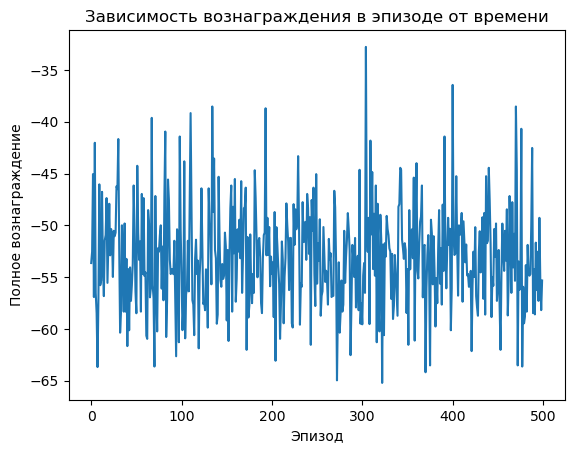

In [35]:
plt.plot(total_reward_episode)
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()